Τμήμα Ηλεκτρολόγων Μηχανικών και Μηχανικών Υπολογιστών  
Αριθμητική Ανάλυση
# Εργασία Εξαμήνου
Ακαδημαϊκό Έτος 2025
| Ονοματεπώνυμο | ΑΕΜ |
|---------------|-----|
| Γερασίμου Δημήτριος | 10813 |
| Γιάννης Σταυριανίδης | 11065 |

## 1. Συλλογή Δεδομένων

Με τη βιβλιοθήκη yfinance λαμβάνουμε ιστορικά δεδομένα της μετοχής της Microsoft, για μία τυπική εργάσιμη εβδομάδα. Κάθε εργάσιμη μέρα περιέχει 13 σημεία ανα 30 λεπτά, από τις 09:30 μέχρι και τις 15:30, σύνολο 65 σημεία για τις 5 μέρες.

In [74]:
import yfinance as yf
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_stock_open_data(stock, start, end):
	yf_stock = yf.Ticker(stock)
	yf_hist = yf_stock.history(start=start, end=end, interval="30m")

	yf_hist['Open'].to_csv('open_prices.csv', header=True)
	return yf_hist['Open'].values

y = get_stock_open_data("MSFT", "2025-05-12", "2025-05-17")

df = pd.DataFrame({
	"Stock Value": y
})

title = "**First 5 Values:**"
md_table = df.head(5).to_markdown(index=True, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

**First 5 Values:**

|    |   Stock Value |
|---:|--------------:|
|  0 |      445.9000 |
|  1 |      441.0950 |
|  2 |      443.9400 |
|  3 |      443.8750 |
|  4 |      443.7600 |

## 2. Πολυωνυμική Προσαρμογή

In [78]:
def split_data(x, percent):
	return x[:int(len(x) * percent)], x[int(len(x) * percent):]

def calculate_error(model, x, y):
	pred = model(x)
	diff = pred - y

	MAE = np.mean(np.abs(diff))
	MSE = np.mean(diff ** 2)

	return MAE, MSE

x = np.arange(len(y))

x_train, x_test = split_data(x, 0.8)
y_train, y_test = split_data(y, 0.8)

# Polynomial degrees to test
degrees = [1, 2, 3]

# Initialize lists to store models, errors, and results
models = []

# Fit polynomial models
for i, degree in enumerate(degrees):
	coeffs = np.polyfit(x_train, y_train, degree)
	poly_func = np.poly1d(coeffs)
	models.append(poly_func)

# Calculate MAE and MSE
train_MAE = np.zeros(len(models))
test_MAE  = np.zeros(len(models))
train_MSE = np.zeros(len(models))
test_MSE  = np.zeros(len(models))

for i in range(len(models)):
	test_MAE[i], test_MSE[i] = calculate_error(models[i], x_test, y_test)
	train_MAE[i], train_MSE[i] = calculate_error(models[i], x_train, y_train)

df = pd.DataFrame({
	"Degree": degrees,
	"Train MAE": train_MAE,
	"Test MAE": test_MAE,
	"Train MSE": train_MSE,
	"Test MSE": test_MSE
})
df["Degree"] = df["Degree"].astype(str)

title = "**MAE and MSE for models, on train and test data:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

best_idx = np.argmin(test_MAE)
best_model = models[best_idx]

df = pd.DataFrame({
	"Degree": [degrees[best_idx]],
	"Train MAE": [train_MAE[best_idx]],
	"Test MAE": [test_MAE[best_idx]],
	"Train MSE": [train_MSE[best_idx]],
	"Test MSE": [test_MSE[best_idx]]
})
df["Degree"] = df["Degree"].astype(str)

title = "**Best Fitting Model:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

**MAE and MSE for models, on train and test data:**

|   Degree |   Train MAE |   Test MAE |   Train MSE |   Test MSE |
|---------:|------------:|-----------:|------------:|-----------:|
|        1 |      1.1788 |     5.8970 |      2.1576 |    35.7621 |
|        2 |      1.1587 |     3.8092 |      1.9101 |    15.8579 |
|        3 |      1.1641 |     2.9545 |      1.8999 |    10.7534 |

**Best Fitting Model:**

|   Degree |   Train MAE |   Test MAE |   Train MSE |   Test MSE |
|---------:|------------:|-----------:|------------:|-----------:|
|        3 |      1.1641 |     2.9545 |      1.8999 |    10.7534 |

### Υπερπροσαρμογή
#### Γιατί τα πολυώνυμα μεγαλύτερου βαθμού παρουσιάζουν υπερπροσαρμογή;
Επειδή ένα πολυώνυμο μεγαλύτερου βαθμού έχει μεγαλύτερη "ευελιξία", μπορεί ανάλογα με τα δεδομένα και τον βαθμό, να προσαρμοστεί υπερβολικά στα δεδομένα εκπαίδευσης. Αυτό σημαίνει ότι προσαρμόζεται αρκετά "καλά" στα δεδομένα εκπαίδευσης, αλλά δεν γενικεύει σωστά σε νέα άγνωστα δεδομένα. Επομένως, αν στα δεδομένα υπάρχει θόρυβος ή τυχαίες διακυμάνσεις, το μοντέλο προσαρμόζεται και σε αυτά, και όχι στην υποκείμενη τάση των δεδομένων.
#### Πώς εντοπίζεται αριθμητικά και πώς περιορίζεται;
Οι βασικές παρατηρήσεις από μοντέλο που υπερπροσαρμώστηκε είναι δραματικές διακυμάνσεις μεταξύ σημείων, κακή συμπεριφορά εκτός του training set και μικρό σφάλμα στο training set αλλά μεγάλο σφάλμα στο test set. Για να το εντοπίσεις αριθμητικά, πρέπει να συγκριθούν οι τιμές του μέσου απόλυτου σφάλματος και του μέσου τετραγωνικού σφάλματος σε testing και training set. Αν είναι μικρά στο training και πολύ μεγαλύτερα στο testing, τότε υπάρχει θέμα υπερπροσαρμογής. Άλλος δείκτης είναι αν το μέσο τετραγωνικό σφάλμα είναι σχετικά μεγάλο σε σύγκριση με πιο απλά μοντέλα.

Για να περιοριστεί, είναι καλό να διαχωρίζονται τα δεδομένα σε testing και training, επιλογή του κατάλληλου βαθμού πολυωνύμου π.χ. αν ένα μοντέλο 3ου βαθμού έχει υψηλότερο MSE από αυτό 2ου βαθμού στο test set, τότε δεν αξίζει, και ιδανικά να απλοποιηθεί το μοντέλο, όσο πιο απλό είναι, τόσο το καλύτερο.

## 3. Πρόβλεψη Επόμενης Ημέρας

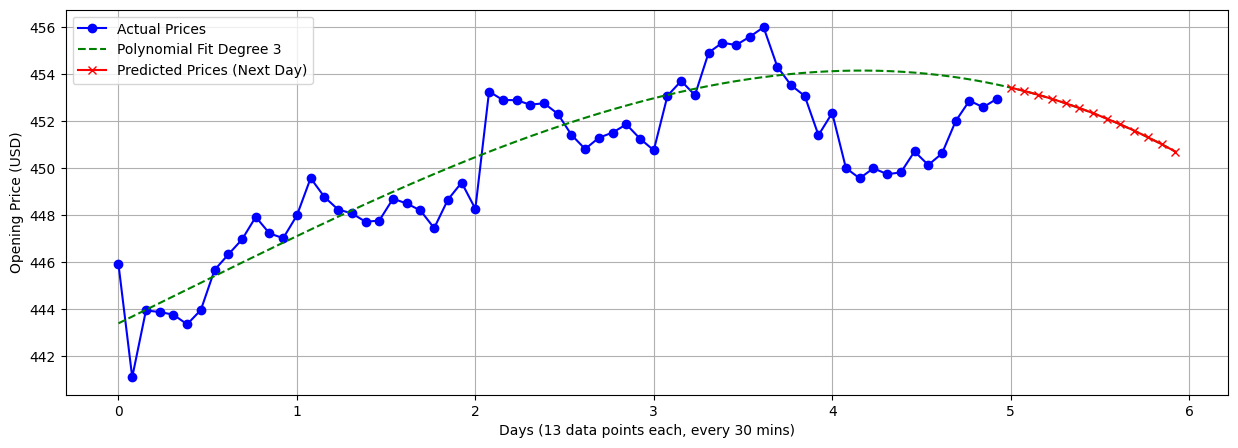

In [67]:
def show_plot(x, y, best_model):
	new_x = np.arange(len(x), len(x) + 1 * 13)
	predicted_prices = best_model(new_x)

	plt.figure(figsize=(15, 5))

	x_fit = np.linspace(0, len(x) + 1 * 13 - 1, 1000)
	y_fit = best_model(x_fit)

	plt.plot(x, y, label="Actual Prices", color='blue', linestyle='-', marker='o')
	plt.plot(x_fit, y_fit, label=f"Polynomial Fit Degree {degrees[best_idx]}", color='green', linestyle='--')
	plt.plot(new_x, predicted_prices, label="Predicted Prices (Next Day)", color='red', linestyle='-', marker='x')

	plt.xlabel('Days (13 data points each, every 30 mins)')
	plt.ylabel('Opening Price (USD)')
	plt.legend()
	plt.grid(True)

	tick_positions = [0, 13, 26, 39, 52, 65, 78]
	tick_labels = ['0', '1', '2', '3', '4', '5', '6']

	plt.xticks(tick_positions, tick_labels)
	plt.show()

show_plot(x, y, best_model)

#### Πώς η επιλογή διαφορετικών βαθμών πολυωνύμων μπορεί να επηρεάσει την ποιότητα πρόβλεψης;
 - Χαμηλός βαθμός πολυωνύμου (π.χ. 1) προσφέρει μια πολύ απλή πρόβλεψη, η οποία όμως μπορεί να χάνει καμπύλες τάσεις. Είναι πιο σταθερή αλλά ενδεχομένως να είναι ανακριβής.
 - Υψηλός βαθμός πολυωνύμου (π.χ. 3) μπορεί να ταιριάξει καλύτερα με τα δεδομένα, αλλά ενδεχομένως να έχει μεγαλύτερη αστάθεια εκτός του training set (overfitting).
#### Πώς μπορούμε να εντοπίσουμε αν η πρόβλεψη είναι ασταθής;
Αν το πολυώνυμο έχει απότομες αυξομειώσεις εκτός των δεδομένων ή αν οι τιμές της πρόβλεψης γίνονται παράλογες είναι ένδειξη ότι η πρόβλεψη είναι ασταθής. Κάτι που ενδέχεται να φανεί και στη γραφική παράσταση.

## 4. Ολοκλήρωση της Καμπύλης Τιμών για Μέση Τιμή

In [ ]:
def trapezoid_rule_area(y, h = 1):
	trapezoid_area = 0.0

	for i in range(len(y) - 1):
		trapezoid_area += (y[i] + y[i + 1]) * h / 2

	return trapezoid_area

def simpson_rule_area(y, h = 1):
	n = len(y)

	if n < 3: raise ValueError

	if n % 2 == 0:
		n -= 1
		print("[INFO] Simpson Rule Calculation needs odd amount of entries. Discarding the last value.")
	
	simpson_area = y[0] + y[n - 1]
	
	for i in range(1, n-1, 2):
		simpson_area+= 4 * y[i]

	for i in range(2, n-2, 2):
		simpson_area+= 2 * y[i]
	
	 area = (h / 3) * simpson_sum
	return simpson_area, n

simpson_ret, simpson_len = simpson_rule_area(y)
simpson_mean_value = simpson_ret / simpson_len
trapezoid_mean_value = trapezoid_rule_area(y) / (len(y))

df = pd.DataFrame({
	"Method": ["Trapezoid Rule", "Simpson's Rule"],
	"Area": [trapezoid_rule_area(y), simpson_ret],
	"Mean Value": [trapezoid_mean_value, simpson_mean_value],
})

title = "**Area and Mean Value by method:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

**Area and Mean Value by method:**

| Method         |       Area |   Mean Value |
|:---------------|-----------:|-------------:|
| Trapezoid Rule | 28803.6217 |     443.1326 |
| Simpson's Rule | 28802.3320 |     443.1128 |

In [ ]:
def trapezoid_rule_func(y, step_count, a, b):
	if step_count<3: raise ValueError
	x_data = np.linspace(a, b, step_count)
	y_data = y(x_data)
	h = (b - a) / (step_count - 1)

	mean = trapezoid_rule_area(y_data, h) / (b - a)
	return mean

model_area = []
for i in range(len(models)):
	model_area.append(trapezoid_rule_func(models[i], 1000, 0, len(y)))

df = pd.DataFrame({
	"Degree": degrees,
	"Area": model_area,
})

df["Degree"] = df["Degree"].astype(str)

title = "**Mean value of each model, by degree:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

model_area = []
idx = []
for i in range(2, 22, 2):
	model_area.append(trapezoid_rule_func(models[2], i, 0, len(y)))
	idx.append(i)

df = pd.DataFrame({
	"Step Size": idx,
	"Area": model_area,
})

df["Step Size"] = df["Step Size"].astype(str)

title = "**Mean value of the cubic model, by step size:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

**Mean value of each model, by degree:**

|   Degree |     Area |
|---------:|---------:|
|        1 | 451.3361 |
|        2 | 450.9016 |
|        3 | 450.7157 |

**Mean value of the cubic model, by step size:**

|   Step Size |     Area |
|------------:|---------:|
|           2 | 448.4147 |
|           4 | 450.4600 |
|           6 | 450.6236 |
|           8 | 450.6687 |
|          10 | 450.6873 |
|          12 | 450.6967 |
|          14 | 450.7021 |
|          16 | 450.7054 |
|          18 | 450.7077 |
|          20 | 450.7093 |

#### Επίδραση του βήματος στην ακρίβεια της αριθμητικής ολοκλήρωσης
Μικρότερα βήματα στην αριθμητική ολοκλήρωση οδηγούν σε μεγαλύτερη ακρίβεια επειδή προσεγγίζουν καλύτερα την καμπύλη της συνάρτησης. Το σφάλμα μειώνεται ταχύτερα στον κανόνα του Simpson ($h^4$) σε σχέση με τον κανόνα του Τραπεζίου ($h^2$). Παραθέτοντας:

Σφάλμα Κανόνα του Simpson:
$$ E_S = \frac{(\frac{h}{2})^4}{180} (\beta - \alpha) f^{(4)} (z),\ \alpha < z < \beta$$

Σφάλμα Κανόνα του Τραπεζίου:
$$ E_T = - \frac{h^2}{12} (\beta - \alpha) f^{''}(z),\ \alpha < z < \beta$$

## 5. Ανίχνευση Ανωμαλιών στα Ιστορικά Δεδομένα

In [79]:
def aitken_neville(x, f, pred):
	n = len(x)
	A = [[0] * n for _ in range(n)]

	for i in range(n):
		A[i][0] = f[i]

	for j in range(1, n):
		for i in range(j, n):
			numerator = (x[j - 1] - pred) * A[i][j - 1] - (x[i] - pred) * A[j - 1][j - 1]
			denominator = x[j - 1] - x[i]
			A[i][j] = numerator / denominator
	
	return A[n - 1][n - 1]

def divided_differences(x, f):
	n = len(x)
	dd_table = [[0] * n for _ in range(n)]

	# Πρώτη στήλη = τιμές f
	for i in range(n):
		dd_table[i][0] = f[i]

	# Υπολογισμός των διηρημένων διαφορών
	for j in range(1, n):
		for i in range(n - j):
			numerator = dd_table[i + 1][j - 1] - dd_table[i][j - 1]
			denominator = x[i + j] - x[i]
			dd_table[i][j] = numerator / denominator

	return [dd_table[0][j] for j in range(n)]

def newton_predict(x_data, coeffs, x_pred):
	n = len(coeffs)
	result = coeffs[0]
	product = 1.0

	for i in range(1, n):
		product *= (x_pred - x_data[i - 1])
		result += coeffs[i] * product

	return result

def anomaly_detection(x, y):
	window_size = 5
	results = []

	for i in range(0, len(x) - window_size, window_size):
		x_window = x[i:i + window_size]
		y_window = y[i:i + window_size]

		x_pred = x[i + window_size]

		y_true = y[i + window_size]

		y_aitken = aitken_neville(x_window, y_window, x_pred)
		coeffs = divided_differences(x_window, y_window)
		y_newton = newton_predict(x_window, coeffs, x_pred)

		error_aitken = abs(y_aitken - y_true)
		error_newton = abs(y_newton - y_true)

		range_val = np.max(y_window) - np.min(y_window)
		std_val = np.std(y_window)
		delta = 0.05 * range_val + 0.5 * std_val

		results.append({
			"x_pred": x_pred,
			"y_true": y_true,
			"Aitken": y_aitken,
			"Newton": y_newton,
			"Error Aitken": error_aitken,
			"Error Newton": error_newton,
			"Delta": delta,
		})

	return results

res = anomaly_detection(x, y)
df = pd.DataFrame(res)

df["x_pred"] = df["x_pred"].astype(str)
title = "**Predicted Values by Aitken-Neville and Newton Divided Differences Methods:**"
md_table = df.to_markdown(index=False, floatfmt=".4f")
display(Markdown(f"{title}\n\n{md_table}"))

**Predicted Values by Aitken-Neville and Newton Divided Differences Methods:**

|   x_pred |   y_true |   Aitken |   Newton |   Error Aitken |   Error Newton |   Delta |
|---------:|---------:|---------:|---------:|---------------:|---------------:|--------:|
|        5 | 443.3500 | 459.8751 | 459.8751 |        16.5251 |        16.5251 |  1.0057 |
|       10 | 447.9250 | 451.7744 | 451.7744 |         3.8494 |         3.8494 |  0.8715 |
|       15 | 448.7800 | 449.9999 | 449.9999 |         1.2199 |         1.2199 |  0.5780 |
|       20 | 448.7000 | 450.0298 | 450.0298 |         1.3298 |         1.3298 |  0.2446 |
|       25 | 449.3900 | 456.9970 | 456.9970 |         7.6070 |         7.6070 |  0.2930 |
|       30 | 452.7100 | 476.1399 | 476.1399 |        23.4299 |        23.4299 |  1.2952 |
|       35 | 451.3000 | 451.9631 | 451.9631 |         0.6631 |         0.6631 |  0.4799 |
|       40 | 453.0900 | 453.6250 | 453.6250 |         0.5350 |         0.5350 |  0.2358 |
|       45 | 455.2500 | 443.0900 | 443.0900 |        12.1600 |        12.1600 |  0.5804 |
|       50 | 453.0800 | 461.7257 | 461.7257 |         8.6457 |         8.6457 |  0.5715 |
|       55 | 450.0000 | 467.3300 | 467.3300 |        17.3300 |        17.3300 |  0.8444 |
|       60 | 450.6300 | 443.0002 | 443.0002 |         7.6298 |         7.6298 |  0.2199 |

#### Σύγκριση πρόβλεψης με πραγματική τιμή

Η πρόβλεψη της επόμενης τιμής με τις μεθόδους Aitken-Neville και Διηρημένων Διαφορών του Newton συγκρίθηκε με την πραγματική τιμή που δίνει το dataset. Στις περισσότερες περιπτώσεις, οι δύο μέθοδοι δίνουν σχεδόν ταυτόσημα αποτελέσματα, καθώς βασίζονται στα ίδια σημεία και παράγουν το ίδιο παρεμβολικό πολυώνυμο.

Παρατηρείται όμως ότι, παρά την ακρίβεια της πρόβλεψης (π.χ. μικρό σφάλμα 1–2 μονάδων), οι τιμές αυτές καταγράφονται ως ανωμαλίες. Αυτό οφείλεται στο ότι το δυναμικά καθοριζόμενο κατώφλι, δ, που χρησιμοποιείται για την ανίχνευση ανωμαλιών είναι πολύ μικρό σε σταθερά σύνολα δεδομένων, προκαλώντας υπερευαισθησία του συστήματος. Επομένως, είναι σημαντικό να αξιολογείται η σχέση του σφάλματος με τη μεταβλητότητα των δεδομένων για να αποφεύγονται ψευδώς θετικές ανωμαλίες.

#### Επίδραση της μεταβλητότητας στον καθορισμό του κατωφλίου

Το κατώφλι ανωμαλίας καθορίζεται δυναμικά με τον τύπο:  
$$δ=0.05⋅Range+0.5⋅σ$$

Ο τύπος αυτός εξασφαλίζει ότι το κατώφλι αυξάνεται όταν τα δεδομένα παρουσιάζουν μεγάλη μεταβλητότητα, και μειώνεται όταν είναι σταθερά. Αυτό είναι απαραίτητο, γιατί σε ευμετάβλητα σύνολα (π.χ. μετοχές με απότομες διακυμάνσεις), τα σφάλματα πρόβλεψης μπορεί να είναι μεγαλύτερα χωρίς να σημαίνουν ανωμαλία. Αντίθετα, σε σταθερά δεδομένα, ακόμα και μια μικρή απόκλιση από την προβλεπόμενη τιμή μπορεί να αποτελεί ένδειξη ανωμαλίας. Ένα σταθερό (μη δυναμικό) κατώφλι ενδέχεται είτε να καταγράφει πολλές ψευδείς ανωμαλίες (υπερευαισθησία) είτε να αποτυγχάνει να εντοπίσει τις πραγματικές (αναξιοπιστία). Συνεπώς, η χρήση ενός κατωφλίου βασισμένου στη μεταβλητότητα επιτρέπει στο σύστημα να προσαρμόζεται στις ιδιαιτερότητες των δεδομένων, αποφεύγοντας την υπερανίχνευση ή την απώλεια πραγματικών ανωμαλιών.